## Desafio - Etapa 2
----

Nessa etapa, serão realizadas as análises a partir do arquivo limpo para um dataframe seguindo os requisitos solicitados.

In [51]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from dotenv import load_dotenv
import os
import io

## Configuração da Conexão com a AWS
---

In [52]:
# Carregando as variáveis de ambiente
load_dotenv()

True

In [53]:
# Pegando as credenciais do ambiente
aws_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
aws_token = os.getenv('AWS_SESSION_TOKEN')
aws_region = 'us-east-1'

In [54]:
# Iniciando o cliente S#
s3_client = boto3.client('s3',
   aws_access_key_id=aws_key_id,
   aws_secret_access_key=aws_secret_key,
   aws_session_token=aws_token,
   region_name=aws_region
)

### Puxando o Arquivo Limpo do Bucket S3
---

Buscando o aruivo limpo do S3 e o salvando em um DataFrame.

In [55]:
# Definindo os nomes do bucket e do arquivo limpo (camada prata)
nome_bucket = "bucket-desafio-2497"
s3_key_limpo = 'limpo/dados_limpos_2021.csv'

try:
    # Pegando objeto do S3
    response = s3_client.get_object(Bucket=nome_bucket, Key=s3_key_limpo)    
    # Lendo o conteúdo do objeto diretamente com o Pandas   
    df_analise = pd.read_csv(response['Body'], sep=';')   

    print("Arquivo limpo carregado com sucesso do S3!")  
    df_analise.info()
    
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo do S3: {e}")

Arquivo limpo carregado com sucesso do S3!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Título              655 non-null    object 
 1   N. tombo            655 non-null    object 
 2   ISBN                598 non-null    float64
 3   Tipo de material    655 non-null    object 
 4   Forma de aquisição  655 non-null    object 
 5   Data do registro    655 non-null    object 
dtypes: float64(1), object(5)
memory usage: 30.8+ KB


## Análises
---

### Análise 1: Descobrindo quais meses o acervo recebe mais itens

Será analisado quais meses o acervo recebeu mais obras.

- **Função de Conversão**

In [56]:
# Convertendo os valores da coluna 'Data do registro' para o tipo data
df_analise['Data do registro'] = pd.to_datetime(df_analise['Data do registro'], format='%d/%m/%Y')

- **Função de Data**

In [ ]:
# Extraindo o número do mês para ordenação
df_analise['Número Mês'] = df_analise['Data do registro'].dt.month
df_analise['Mês de Registro'] = df_analise['Data do registro'].dt.month_name()

- **Função de Agregação**

In [1]:
# Agregando os dados contando os registros por mês
registro_mes = df_analise.groupby(['Número Mês', 'Mês de Registro']).size().reset_index(name='Total Registros')
registro_mes = registro_mes.sort_values('Número Mês')

print(50*'=')
print("        Total de Obras Incorporados por Mês")
print(50*'=')
print(registro_mes[['Mês de Registro', 'Total Registros']].to_string(index=False))

NameError: name 'df_analise' is not defined

### ***Visualização***


SUCESSO: Gráfico 'visualizacoes/grafico_sazonalidade_mensal.png' enviado para o bucket 'bucket-desafio-2497'.


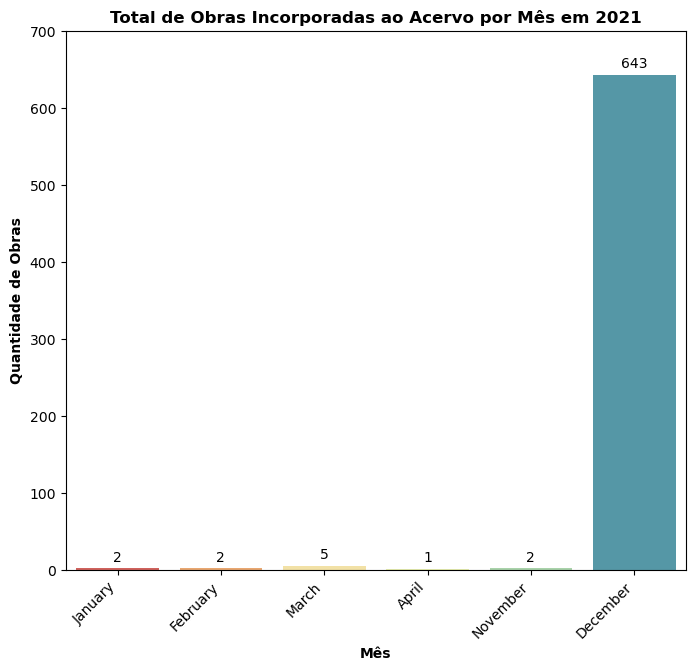

In [ ]:
plt.figure(figsize=(8, 7))
ax = sns.barplot(
    x='Mês de Registro',
    y='Total Registros',
    data=registro_mes,
    palette='Spectral',
    hue='Mês de Registro',
    legend=False,
    order=registro_mes['Mês de Registro']
)

#  Adicionando o rótulo com o valor em cada barra
for bar in ax.patches:
    # A altura da barra 
    height = bar.get_height()
    
    # Usando ax.annotate para posicionar o texto
    ax.annotate(f'{int(height)}',                  # O texto do rótulo 
                xy=(bar.get_x() + bar.get_width() / 2, height), # A posição do texto
                xytext=(0, 3),                     # Deslocando vertical de 3 pontos para cima
                textcoords="offset points",
                ha='center',                       # Centralizando horizontalmente
                va='bottom')                       # Alinhando pela base

# Customizando o gráfico 
plt.title('Total de Obras Incorporadas ao Acervo por Mês em 2021', fontsize=12, fontweight='bold')
plt.xlabel('Mês', fontweight='bold')
plt.ylabel('Quantidade de Obras', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 700)

# Criando um buffer em memória para salvar a imagem
img_data = io.BytesIO()
# Salvando a figura atual no buffer em formato PNG de alta qualidade
plt.savefig(img_data, format='png', dpi=300, bbox_inches='tight')
img_data.seek(0)
# Caminho da iamgem no S3
s3_key_barras = 'visualizacoes/grafico_sazonalidade_mensal.png'

# Fazendo o upload do buffer para o S3
try:
    s3_client.upload_fileobj(img_data, nome_bucket, s3_key_barras)
    print(f"\nSUCESSO: Gráfico '{s3_key_barras}' enviado para o bucket '{nome_bucket}'.")
except Exception as e:
    print(f"\nERRO: Falha ao enviar o gráfico para o S3. Erro: {e}")

plt.show()

### Análise 2: Descobrindo quais livros contêm a palavra "História" no título e Modo de Aquisição

- **Função de String**

In [60]:
# Usando.str.contains() para buscar a palavra 'história' 
contem_historia = df_analise['Título'].str.contains("história", case=False, na=False)

- **Filtro com 2 Operadores Lógicos**

In [61]:
# Buscando os títulos com 'história' na coluna 'Tipo de material' com valor 'Livro'
livros_de_historia = df_analise[
    (df_analise['Tipo de material'] == 'LIVRO') & 
    (contem_historia)
]
print(50*'=')
print(f"Foram encontrados {len(livros_de_historia)} livros sobre 'história'.")
print(50*'=')
print("          Forma de aquisição desses livros")
print(50*'=')
print(livros_de_historia['Forma de aquisição'].value_counts().to_string())
print(50*'=')


Foram encontrados 20 livros sobre 'história'.
          Forma de aquisição desses livros
Forma de aquisição
DL                  19
NÃO ESPECIFICADA     1


### ***Visualização***


SUCESSO: Gráfico 'visualizacoes/grafico_proporcao_aquisicao_historia.png' enviado para o bucket 'bucket-desafio-2497'.


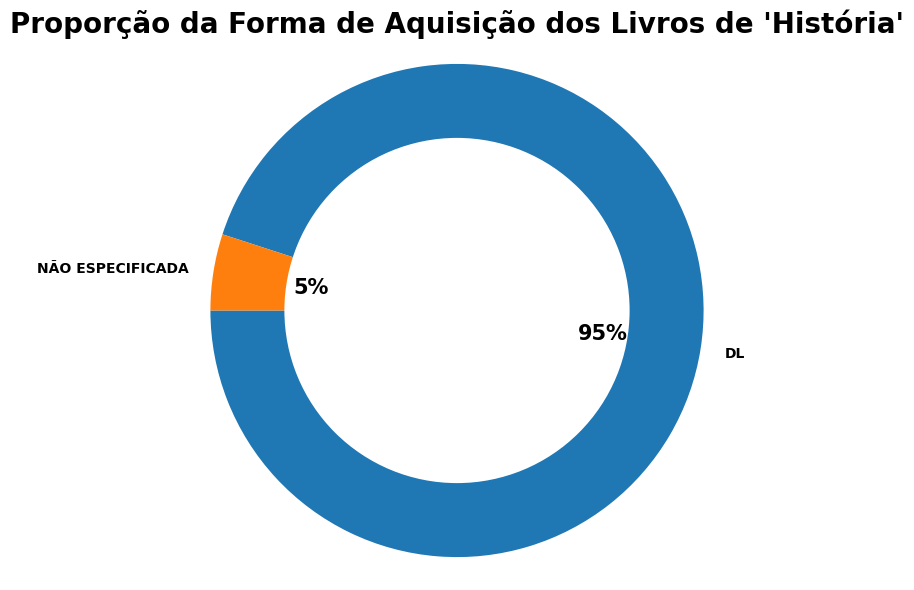

In [62]:
# Preparando os dados para o gráfico 
dados_para_pizza = livros_de_historia['Forma de aquisição'].value_counts()

# Criando a figura do gráfico
plt.figure(figsize=(7, 7)) 

# Gerando o gráfico de pizza
patches, textos, autotextos = plt.pie(
    dados_para_pizza.values,                  
    labels=dados_para_pizza.index,            # Os rótulos de cada fatia 
    autopct='%1.0f%%',                        # Formato para mostrar a porcentagem em cada fatia
    startangle=180,                            # Ângulo inicial para a primeira fatia 
    colors=sns.color_palette('tab10', len(dados_para_pizza)), # Paleta de cores
    textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'}
)

# Criando um círculo branco
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()  
fig.gca().add_artist(centre_circle) 

# Configurando Informações
plt.setp(autotextos, size=15, weight="bold", color='black')
plt.title("Proporção da Forma de Aquisição dos Livros de 'História'", fontsize=20, fontweight='bold')
plt.axis('equal')  # Garantindo que a pizza seja redonda

# Criando um buffer em memória para salvar a imagem
img_data = io.BytesIO()
# Salvando a figura atual no buffer em formato PNG de alta qualidade
plt.savefig(img_data, format='png', dpi=300, bbox_inches='tight')
img_data.seek(0)
# Caminho da iamgem no S3
s3_key_rosca = 'visualizacoes/grafico_proporcao_aquisicao_historia.png'

# Fazendo o upload do buffer para o S3
try:
    s3_client.upload_fileobj(img_data, nome_bucket, s3_key_rosca)
    print(f"\nSUCESSO: Gráfico '{s3_key_rosca}' enviado para o bucket '{nome_bucket}'.")
except Exception as e:
    print(f"\nERRO: Falha ao enviar o gráfico para o S3. Erro: {e}")

plt.show()

### Análise 3: Classificação por Semestre de Registro

- **Função Condicional**

In [63]:
# Usando np.where() para criar a nova coluna 'Semestre'
df_analise['Semestre'] = np.where(df_analise['Data do registro'].dt.month <= 6, 
                                  '1º Semestre', 
                                  '2º Semestre')


In [64]:
# Agregando os dados para ver o resultado da classificação
contagem_semestre = df_analise['Semestre'].value_counts()
contagem_semestre = contagem_semestre.sort_index(ascending=True)

print(50*'=')
print("      Total de itens incorporados por semestre")
print(50*'=')
print(contagem_semestre.to_string())


      Total de itens incorporados por semestre
Semestre
1º Semestre     10
2º Semestre    645



SUCESSO: Gráfico 'visualizacoes/grafico_comparativo_semestre.png' enviado para o bucket 'bucket-desafio-2497'.


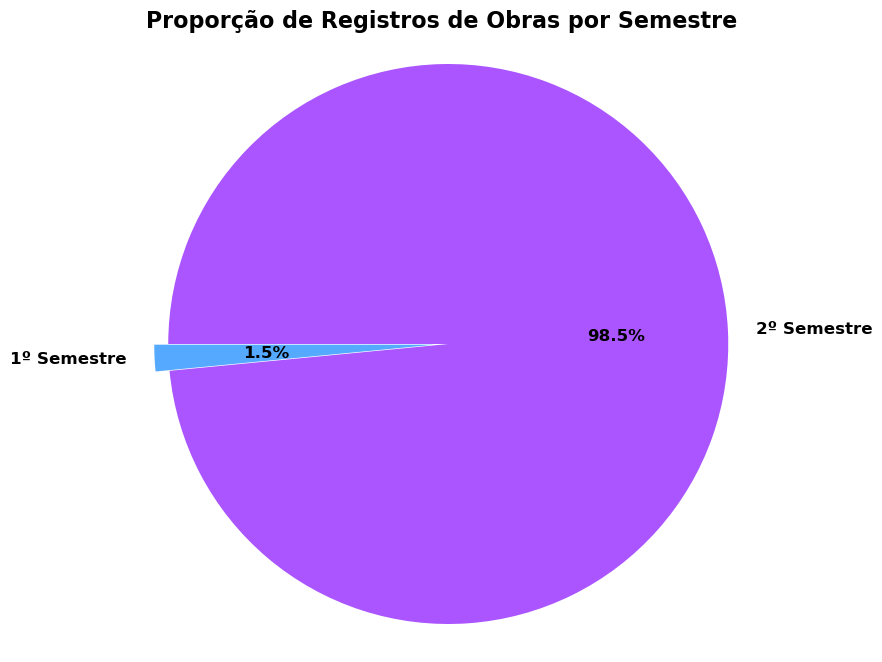

In [65]:
# Criando a figura 
plt.figure(figsize=(8, 8))

# Selecionando as cores 
colors = sns.color_palette('cool', len(contagem_semestre))

# Gerando o Gráfico de Pizza 
patches, texts, autotexts = plt.pie(
    contagem_semestre,
    labels=contagem_semestre.index,
    autopct='%1.1f%%',              # Formato da porcentagem 
    startangle=180,                
    colors=colors,
    explode=(0.05, 0)             
)

# Customizando os textos das porcentagens 
plt.setp(autotexts, size=12, weight="bold", color='black')
# Customizando os textos dos rótulos
plt.setp(texts, size=12, fontweight='bold')

# Adicionando o título
plt.title('Proporção de Registros de Obras por Semestre', fontsize=16, fontweight='bold')
plt.axis('equal') # Garantindo que a pizza seja um círculo

# Criando um buffer em memória para salvar a imagem
img_data = io.BytesIO()
# Salvando a figura atual no buffer em formato PNG de alta qualidade
plt.savefig(img_data, format='png', dpi=300, bbox_inches='tight')
img_data.seek(0)
# Caminho da iamgem no S3
s3_key_grafico = 'visualizacoes/grafico_comparativo_semestre.png'

# Fazendo o upload do buffer para o S3
try:
    s3_client.upload_fileobj(img_data, nome_bucket, s3_key_grafico)
    print(f"\nSUCESSO: Gráfico '{s3_key_grafico}' enviado para o bucket '{nome_bucket}'.")
except Exception as e:
    print(f"\nERRO: Falha ao enviar o gráfico para o S3. Erro: {e}")

plt.show()